In [1]:
# Drive mount for dataset and result save access
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/nimbronet_final/

Mounted at /content/drive
/content/drive/MyDrive/nimbronet_final


In [2]:
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from utils.dataloader import (
    blobDataset,
    SegDataset,
    blob_dataloader,
    segmentation_dataloader,
)
from utils.model import nimbrRoNet2
from utils.metrics import metrics
from utils.losses import losses
from torchsummary import summary

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


## Dataloader and Model Initialization

In [3]:
parser = argparse.ArgumentParser(description="Nimbronet training")
parser.add_argument(
    "-b", "--batch_size", default=1, type=int, help="mini-batch size (default: 8)"
)
parser.set_defaults(augment=True)
args = parser.parse_args(args=[])

blob_dir = '/content/drive/MyDrive/Nimbronet/data/blob/'
seg_dir =  '/content/drive/MyDrive/Nimbronet/data/segmentation/'

transfs = transforms.Compose(
        [
            transforms.Resize((480, 640)),
            transforms.ToTensor(),
        ]
    )

# Initializing the detection and segmentation dataloaders
_, _, testbdataloader, len_blob = blob_dataloader(blob_dir, transfs, args)
_, _, testsdataloader, len_seg = segmentation_dataloader(seg_dir, transfs, args)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

nnet2 = nimbrRoNet2()
nnet2 = nnet2.to(device)
nnet2.load_state_dict(torch.load('/content/drive/MyDrive/Nimbronet/Final_model_300.pt')) #loading pretrained model weights

summary(nnet2,(3,480,640))

Device used:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]           9,408
       BatchNorm2d-2         [-1, 64, 240, 320]             128
              ReLU-3         [-1, 64, 240, 320]               0
         MaxPool2d-4         [-1, 64, 120, 160]               0
            Conv2d-5         [-1, 64, 120, 160]          36,864
       BatchNorm2d-6         [-1, 64, 120, 160]             128
              ReLU-7         [-1, 64, 120, 160]               0
            Conv2d-8         [-1, 64, 120, 160]          36,864
       BatchNorm2d-9         [-1, 64, 120, 160]             128
             ReLU-10         [-1, 64, 120, 160]               0
       BasicBlock-11         [-1, 64, 120, 160]               0
           Conv2d-12         [-1, 64, 120, 160]          36,864
      BatchNorm2d-13         [-1, 64, 120, 160]             128
             ReLU-14         [-1, 64, 1

## Detection dataset samples

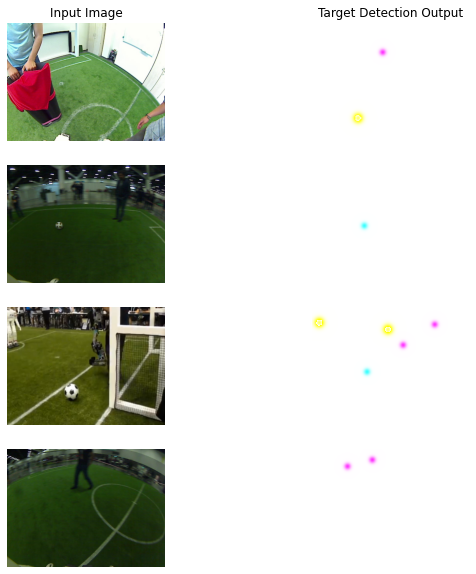

In [25]:
f, axarr = plt.subplots(4,2, figsize=(10., 10.))
axarr[0,0].title.set_text('Input Image')
axarr[0,1].title.set_text('Target Detection Output')

for idx, data in enumerate(testbdataloader):
  image, target = data[0][0], data[1][0]

  image = transforms.ToPILImage()(image)
  target = transforms.ToPILImage()(target)

  axarr[idx,0].imshow(image)
  axarr[idx,0].axis('off')

  axarr[idx,1].imshow(target)
  axarr[idx,1].axis('off')
  
  if idx == 3:
    break
plt.show()


## Segmentation dataset samples

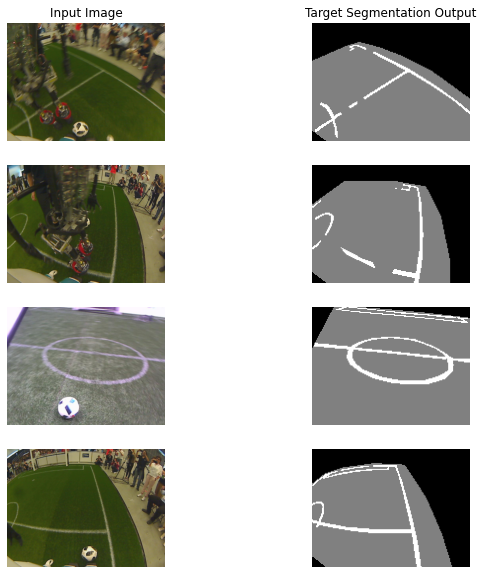

In [24]:
f, axarr = plt.subplots(4,2, figsize=(10., 10.))
axarr[0,0].title.set_text('Input Image')
axarr[0,1].title.set_text('Target Segmentation Output')

for idx, data in enumerate(testsdataloader):
  image, target = data[0][0], data[1][0]

  image = transforms.ToPILImage()(image)
  # target = transforms.ToPILImage()(target)

  axarr[idx,0].imshow(image)
  axarr[idx,0].axis('off')

  axarr[idx,1].imshow(target,cmap='gray')
  axarr[idx,1].axis('off')
  
  if idx == 3:
    break
plt.show()


## Network output visualization

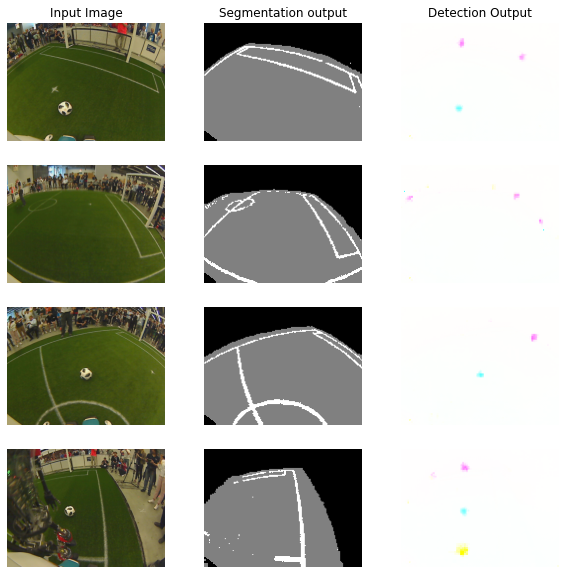

In [18]:
f, axarr = plt.subplots(4,3, figsize=(10., 10.))
axarr[0,0].title.set_text('Input Image')
axarr[0,1].title.set_text('Segmentation output')
axarr[0,2].title.set_text('Detection Output')

for idx, data in enumerate(testsdataloader):
  image, target = data[0], data[1]
  seg_pred,blob_pred = nnet2(image.to(device))

  image = transforms.ToPILImage()(image[0])

  blob_pred = torch.transpose(blob_pred,1,2)
  blob_pred = torch.transpose(blob_pred,2,3)
  blob_pred = blob_pred.squeeze().detach().cpu().numpy()

  seg_pred = torch.argmax(seg_pred,1,keepdim=True).squeeze().detach().cpu()

  
  axarr[idx,0].imshow(image)
  axarr[idx,0].axis('off')

  axarr[idx,1].imshow(seg_pred, cmap='gray')
  axarr[idx,1].axis('off')

  axarr[idx,2].imshow(np.clip(blob_pred,0,1))
  axarr[idx,2].axis('off')
  
  if idx == 3:
    break
plt.savefig('results_all.pdf',bbox_inches='tight')
plt.show()